In [2]:
import numpy as np

import getdist
import getdist.plots
import getdist.gaussian_mixtures

%matplotlib inline
import matplotlib.pyplot as plt

## Make Fisher forecast plots

In [16]:
param_names = ["omegach2", "omegabh2", "ns", "as", "h",
            #    "s8", "sigma8", "omegam"
              ]
labels = {"omegach2": r"\Omega_c h^2",
          "omegabh2": r"\Omega_b h^2",
          "omegam": r"\Omega_m",
          "sigma8": r"\sigma_8",
          "s8": r"S8",
          "h": r"h",
          "ns": r"n_s",
          "as": r"A_s",}
fiducial_cosmology = {"omegach2": 0.1109019496,
                      "omegabh2": 0.02258368,
                      "ns": 0.963,
                      "as": 2.16053e-9,
                      "h": 0.71,
                    #   "sigma8": 0.8,
                    #   "s8": 0.7516,
                    #   "omegam": 0.2648
                      }

fisher_forecast = {}

fisher_matrix = np.loadtxt("../cosmosis/output/star_3x2pt_samples_fisher.txt")[:5, :5]
fisher_forecast["3x2pt"] = getdist.gaussian_mixtures.GaussianND(
                                    mean=list(fiducial_cosmology.values()),
                                    cov=np.linalg.inv(fisher_matrix),
                                    names=param_names, 
                                    label="Fisher, 3x2pt")

fisher_matrix = np.loadtxt("../cosmosis/output/star_EE_only_samples_fisher.txt")[:5, :5]
fisher_forecast["EE_only"] = getdist.gaussian_mixtures.GaussianND(
                                    mean=list(fiducial_cosmology.values()),
                                    cov=np.linalg.inv(fisher_matrix),
                                    names=param_names, 
                                    label="Fisher, cosmic shear only")

fisher_matrix = np.loadtxt("../cosmosis/output/star_nn_only_samples_fisher.txt")[:5, :5]
fisher_forecast["nn_only"] = getdist.gaussian_mixtures.GaussianND(
                                    mean=list(fiducial_cosmology.values()),
                                    cov=np.linalg.inv(fisher_matrix),
                                    names=param_names, 
                                    label="Fisher, clustering only")

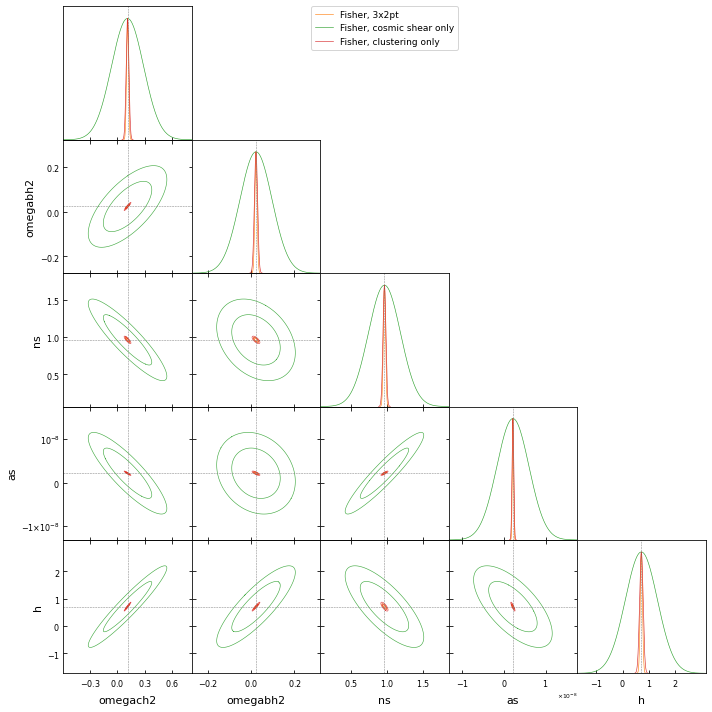

In [17]:
g = getdist.plots.get_subplot_plotter()

chains = [
            fisher_forecast["3x2pt"],
            fisher_forecast["EE_only"],
            fisher_forecast["nn_only"]
                 ]
contour_args = [{"alpha": 0.9}]*len(chains)
contour_colors =  [f"C{i+1}" for i in range(len(chains))]

line_args = [{"color": f"C{i+1}"} for i in range(len(chains))]

# contour_args[-1] = {"filled": True, "alpha": 1.0}
# contour_colors[-1] = "C0"
# line_args[-1].update({"color": "C0", "lw": 3})

g.triangle_plot(chains,
                contour_args=contour_args,
                contour_colors=contour_colors,
                line_args=line_args,
                params=fiducial_cosmology.keys(),
                markers=fiducial_cosmology)


## Compute "detection" significances

In [39]:
d = np.loadtxt("../cosmosis/output/EE_only/datablock/data_vector/firecrown_data.txt")
Psi = np.loadtxt("../cosmosis/output/EE_only/datablock/data_vector/firecrown_inverse_covariance.txt")
EE_significance = np.sqrt(d @ Psi @ d)

d = np.loadtxt("../cosmosis/output/nn_only/datablock/data_vector/firecrown_data.txt")
Psi = np.loadtxt("../cosmosis/output/nn_only/datablock/data_vector/firecrown_inverse_covariance.txt")
nn_significance = np.sqrt(d @ Psi @ d)

## Plot theory and errorbars

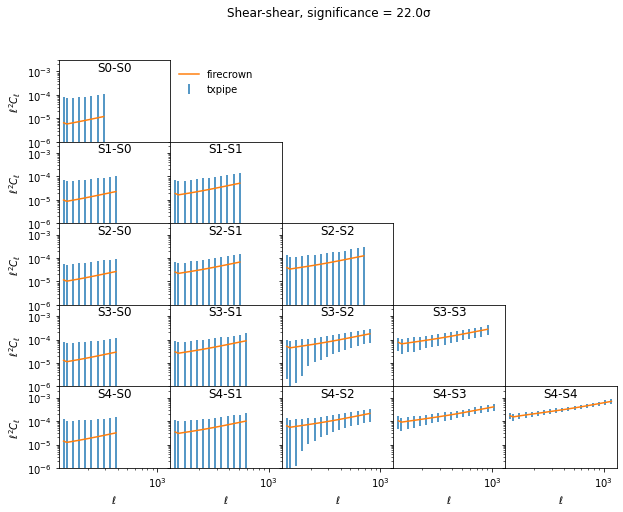

In [45]:
n_source = 5

fig, ax = plt.subplots(n_source, n_source, sharex=True, sharey=True, figsize=(2*n_source, 1.5*n_source))
fig.subplots_adjust(hspace=0, wspace=0)
[a.axis("off") for a in ax.flat]

errors = np.sqrt(np.diag(np.linalg.inv(np.loadtxt(f"../cosmosis/output/EE_only/datablock/data_vector/firecrown_inverse_covariance.txt"))))
idx = 0

for i in range(n_source):
    for j in range(i+1):
        data = np.loadtxt(f"../cosmosis/output/EE_only/datablock/data_vector/data_galaxy_shear_cl_ee_source_{i}_source_{j}.txt")
        theory = np.loadtxt(f"../cosmosis/output/EE_only/datablock/data_vector/theory_galaxy_shear_cl_ee_source_{i}_source_{j}.txt")
        ell = np.loadtxt(f"../cosmosis/output/EE_only/datablock/data_vector/ell_or_theta_galaxy_shear_cl_ee_source_{i}_source_{j}.txt")

        a = ax[i,j]
        a.axis("on")
        u = ell**2
        a.errorbar(ell, u*data, u*errors[idx:idx+len(ell)], ls="none", label="txpipe")
        idx += len(ell)
        a.loglog(ell, u*theory, label="firecrown")
        a.set_title(f"S{i}-S{j}", y=0.8)

[a.set_xlabel(r"$\ell$") for a in ax[-1]]
[a.set_ylabel(r"$\ell^2 C_\ell$") for a in ax[:,0]]

ax[0,0].legend(frameon=False, loc=2, bbox_to_anchor=(1,1))
ax[0,0].set_ylim(1e-6, 3e-3)
fig.suptitle(f"Shear-shear, significance = {EE_significance:.1f}σ")
fig.savefig("plots/shear_shear.png", facecolor="white", dpi=300)

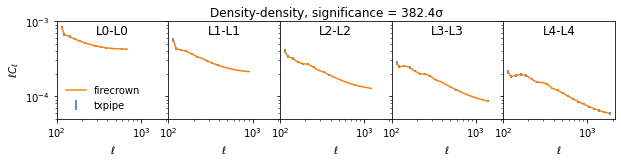

In [46]:
n_lens = 5

fig, ax = plt.subplots(1, n_lens, sharex=True, sharey=True, figsize=(2*n_lens, 2))
fig.subplots_adjust(hspace=0, wspace=0, bottom=0.2)

errors = np.sqrt(np.diag(np.linalg.inv(np.loadtxt(f"../cosmosis/output/nn_only/datablock/data_vector/firecrown_inverse_covariance.txt"))))
idx = 0

for i in range(n_lens):
    data = np.loadtxt(f"../cosmosis/output/nn_only/datablock/data_vector/data_galaxy_density_cl_lens_{i}_lens_{i}.txt")
    theory = np.loadtxt(f"../cosmosis/output/nn_only/datablock/data_vector/theory_galaxy_density_cl_lens_{i}_lens_{i}.txt")
    ell = np.loadtxt(f"../cosmosis/output/nn_only/datablock/data_vector/ell_or_theta_galaxy_density_cl_lens_{i}_lens_{i}.txt")

    a = ax[i]
    u = ell
    a.errorbar(ell, u*data, u*errors[idx:idx+len(ell)], ls="none", label="txpipe")
    idx += len(ell)
    a.loglog(ell, u*theory, label="firecrown")
    a.set_title(f"L{i}-L{i}", y=0.8)

[a.set_xlabel(r"$\ell$") for a in ax]
ax[0].set_ylabel(r"$\ell C_\ell$")

ax[0].legend(frameon=False)
fig.suptitle(f"Density-density, significance = {nn_significance:.1f}σ")
fig.savefig("plots/density_density.png", facecolor="white", dpi=300)